The GARROTXA Simulation (GAlaxy high Resolution Runs in a cOsmological conTeXt using ART) is a set of Eulerian hydrodynamics $+$ N-body ART. The code employs adaptive mesh refinement to selectively increase resolution around a specified region of interest, and were used to obtain high-resolution Milky Way-sized galaxies. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from os import path
import array
import matplotlib.colors as mcolors
import cmasher as cmr
import sys
from scipy.ndimage import gaussian_filter
from scipy import stats

import sys
 
# setting path
sys.path.append('/home/bego/GARROTXA//GalaDyn/')
from snapshot import *
from config import *


/home/bego/anaconda3/lib/python3.8/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/bego/.config/yt/ytrc is deprecated in favor of /home/bego/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [5]:
limit_AB = 25
rangex=[-limit_AB,limit_AB]
rangey=[-limit_AB,limit_AB]
binsx=100
binsy=100

surface = (((rangex[1]-rangex[0])/binsx)**2)*1e6
aspect=(rangex[1]-rangex[0])/(rangey[1]-rangey[0])
deltax=(rangex[1]-rangex[0])/binsx
deltay=(rangey[1]-rangey[0])/binsy

sigma=5
plt.rc('font', family='serif')

In [6]:
def add_bar ( fig, i, aplot, label):
    cbar_ax = fig.add_axes([ 0.2*i + 0.002, 0.98,0.18, 0.025])
    cbar = fig.colorbar(aplot, cax=cbar_ax,orientation='horizontal')          
    cbar.ax.tick_params(labelsize= 10,top= True,bottom= False,
                        labeltop=True,  labelbottom= False)
    cbar.set_label(label=f"{label}", size = 12)
    cbar.ax.tick_params(labelsize= 10)

    
def calculate_2D_histogram(variable, df):
    rangex=[-limit_AB,limit_AB]
    rangey=[-limit_AB,limit_AB]
    binsx=100
    binsy=100
    
    stat0=stats.binned_statistic_2d(df["X"], df["Y"], df[variable], 
                            statistic='median', bins=(binsx,binsy), 
                            range=[rangex,rangey])
    im=np.flip(stat0.statistic.T*1.,0)
    #z = ax.imshow(im,cmap=colormap, extent=[rangex[0],rangex[1],rangey[0],rangey[1]],aspect=aspect,vmin=-vmin,vmax=vmax)
    return im

def draw_dynamical_maps(df):
    fig, ax = plt.subplots(1,5,figsize = (12,3),sharex = True,sharey = True)

    binsx=100
    binsy=100
    h0,xedges,yedges=np.histogram2d(df['X'],df['Y'],bins=[binsx,binsy])

    h2Ds=gaussian_filter(h0, sigma)
    h0=h0/h2Ds-1.

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax[0].imshow(h0.T, vmin=-1, vmax=1, cmap='gist_yarg', extent=extent, origin='lower')
    ax[0].set_box_aspect(1)

    ax[0].set_title(f"{snapshot.lb:.2f} Gyr", fontsize = 10)
    ax[0].set_ylabel("Y [kpc]", fontsize = 12)
    im = calculate_2D_histogram('Z', df)
    z = ax[1].imshow(im,cmap='PuOr_r', extent=[rangex[0],rangex[1],rangey[0],rangey[1]],aspect=aspect,vmin=-0.5,vmax=0.5)

    #Vz plot
    im = calculate_2D_histogram('VZ', df)
    vz =  ax[2].imshow(im,cmap='seismic', extent=[rangex[0],rangex[1],rangey[0],rangey[1]]
       ,aspect=aspect,vmin=-20,vmax=20)

    #Vphi plot
    im = calculate_2D_histogram('Vphi',df)
    vphi = ax[3].imshow(im,cmap='cmr.guppy', extent=[rangex[0],rangex[1],rangey[0],rangey[1]]
        ,aspect=aspect,vmin=-240,vmax=-160)

    #Vr plot
    im = calculate_2D_histogram('VR', df)
    vr = ax[4].imshow(im,cmap='rainbow', extent=[rangex[0],rangex[1],rangey[0],rangey[1]]
        ,aspect=aspect,vmin=-40,vmax=40)

    
    for i in range(5):
        ax[i].set_xlabel("X [kpc]", fontsize = 12)
    add_bar (fig, 1, z, "Z [kpc]")
    add_bar (fig, 2, vz, "$V_{Z}$ [km s$^{-1}$]")
    add_bar (fig, 3, vphi, "$V_{\phi}$ [km s$^{-1}$]")
    add_bar (fig, 4, vr, "$V_{R}$ [km s$^{-1}$]")

    plt.subplots_adjust(left=0 ,bottom= 0.12, right=0.99, top=0.89, wspace=0.07, hspace= 0.09)
    plt.show()


In [7]:
name = 999
snapshot = Snapshot(name)

Initializing snapshot 999
Lookback time: 0.0132086769907413 Gyr


In [27]:
snapshot.load_stars()

stars = snapshot.filter_disk_particles_by_age()

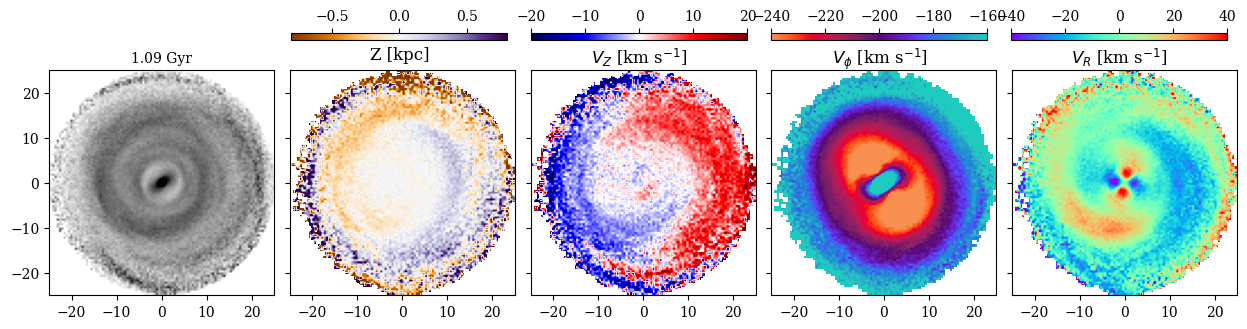

In [6]:
draw_dynamical_maps (stars)

In [7]:
snapshot.load_gas()

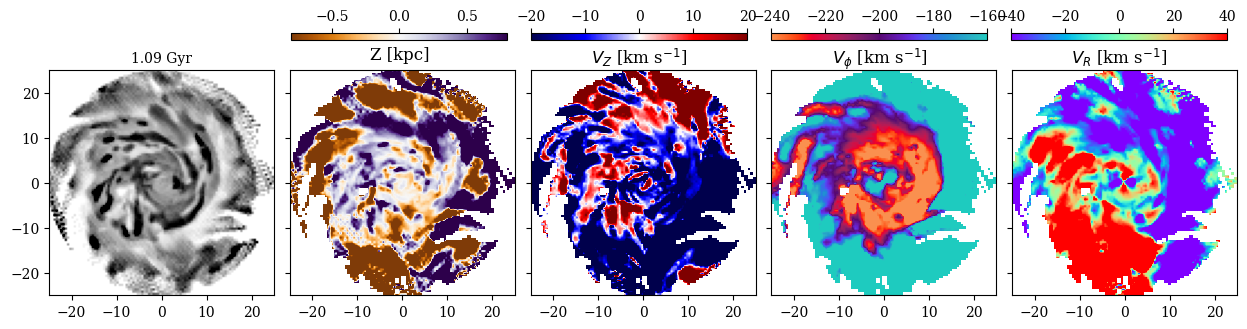

In [8]:
gas = snapshot.gas[(snapshot.gas["Temperature"]<1e6)&(np.abs(snapshot.gas["Z"])<5)&(snapshot.gas["R"]<25)]
sigma =5
draw_dynamical_maps (gas)

In [8]:
snapshot.load_dm()

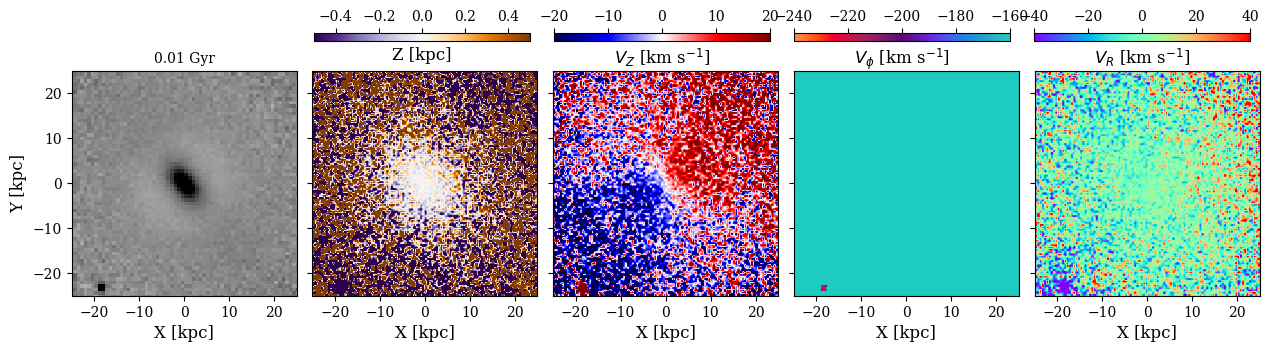

In [11]:
dm = snapshot.dm[(np.abs(snapshot.dm["Z"])<15)&(snapshot.dm["R"]<40)]
sigma =5
draw_dynamical_maps (dm)


In [11]:
snapshot.load_accelerations() 

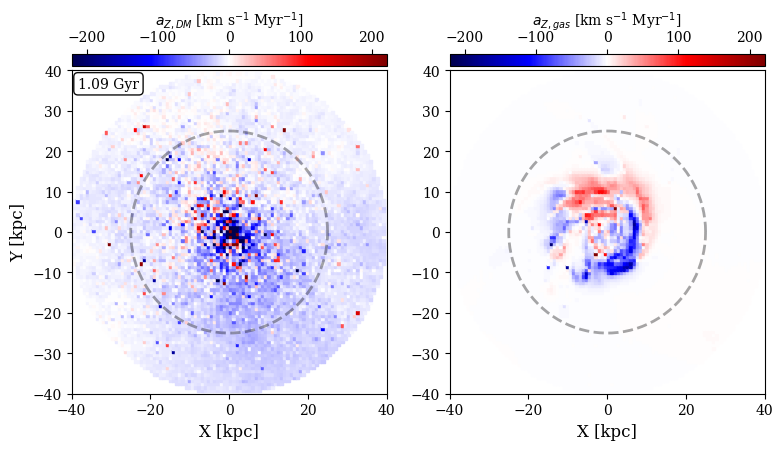

In [12]:
props = dict(boxstyle='round', facecolor='white', alpha=0.95)

rango_z=7e-15*SECONDS_TO_MYR 
size = 5
ancho = 40

theta = np.linspace(0, 2*np.pi, 100)
r1 = 25
x = r1*np.cos(theta)
y = r1*np.sin(theta)

fig, ax = plt.subplots(1, 2,figsize = (7,5))

dm = ax[0].scatter(snapshot.az_dm.X,snapshot.az_dm.Y, marker='s', c=snapshot.az_dm.az*SECONDS_TO_MYR , 
            cmap= "seismic", s = size, vmin =-rango_z, vmax = rango_z)
gas = ax[1].scatter(snapshot.az_gas.X,snapshot.az_gas.Y, marker='s', c=snapshot.az_gas.az*SECONDS_TO_MYR, 
            cmap= "seismic", s = size, vmin =-rango_z, vmax = rango_z)

for k in range(2):
    ax[k].set_xlabel("X [kpc]", fontsize = 12)
    ax[k].set_xlim(-ancho,ancho)
    ax[k].set_ylim(-ancho,ancho)
    
ax[0].set_ylabel("Y [kpc]", fontsize = 12)

for i in range(0,2):
    ax[i].plot(x, y, "--", color = "black", alpha = 0.35, lw = 2)
    
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[1].tick_params(axis='both', which='major', labelsize=10)

ax[0].text(0.02, 0.98,f"{snapshot.lb:.2f} Gyr", transform=ax[0].transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

fig.colorbar(dm, ax=ax[0], label =  "$a_{Z, DM}$ [km s$^{-1}$ Myr$^{-1}$]",aspect=25,pad = 0.01, location = "top")
fig.colorbar(gas, ax=ax[1], label =  "$a_{Z, gas}$ [km s$^{-1}$ Myr$^{-1}$] ",aspect=25,pad = 0.01, location = "top")

plt.subplots_adjust(left=0 ,bottom= 0.12, right=0.99, top=0.89, wspace=0.2, hspace= 0.09)

plt.show()
